In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from matplotlib import pyplot as plt
from math import pi, exp, sin, cos

## Problem Statement
Consider the following PDE.

$$
\frac{\partial u}{\partial t} =
\frac{\partial^2 u}{\partial x^2}
- e^{-t} sin(\pi x) (1 - \pi^2), \quad  -1 < x < 1, \quad t > 0
$$

Subject to the boundary conditions
$$
u(x=-1, t) = u(x=1,t) = 0
$$

and the initial condition
$$
u(x, t=0) = sin(x \pi)
$$

The exact solution to the PDE is
$$
u(x,t) = e^{-t} sin(x \pi)
$$

In [4]:
#use GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [5]:
# Define the exact solution
def exact_solution(x, t):
  return torch.exp(-t) * torch.sin(pi * x)

In [6]:
# Define the range of x and t
x_0, x_f = -1.0, 1.0
t_0, t_f = 0.0, 1.0
x = torch.linspace(x_0, x_f, 300)
t = torch.linspace(t_0, t_f, 300)

## Helper function for plotting

In [36]:
def plot_data(x_points, t_points, exact, approx=None, epoch=None, title=None):
  figure = plt.figure(tight_layout=True, dpi=100)
  ax = figure.add_subplot(111)
  if approx == None or epoch == None:
    ax.set_title("exact Solution")
    ax.set_xlabel("x")
    ax.set_ylabel("t")
    x, t = torch.meshgrid(x_points, t_points, indexing="ij")
    u_exact = exact_solution(x, t)
    color_map = ax.pcolormesh(x, t, u_exact, cmap="rainbow")
    figure.colorbar(color_map)

  elif approx != None and epoch != None:
    ax.set_title(f"NN approximation at {epoch} iterations")
    ax.set_xlabel("x")
    ax.set_ylabel("t")
    x, t = torch.meshgrid(x_points, t_points)
    color_map = ax.pcolormesh(x, t, approx, cmap="rainbow")
    figure.colorbar(color_map)

  #optional title
  if type(title) != type(None):
    ax.set_title(title)

  plt.show()

# Show the exact solution

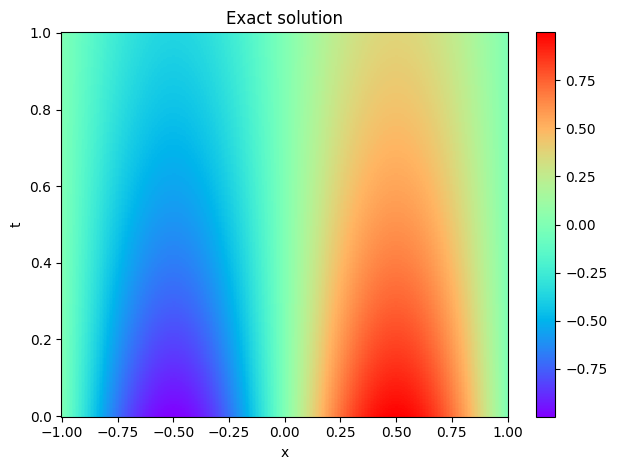

In [37]:
plot_data(x, t, exact_solution, title="Exact solution")

# Define the neural network

In [12]:
# Define the neural network
# Building the neural network
class XDESolver(nn.Module):
  def __init__(self, n_input, n_output, n_hidden_layers, n_hidden_units):
    super().__init__()
    self.n_input = n_input
    self.n_output = n_output
    self.n_hidden_layers = n_hidden_layers
    self.n_hidden_units = n_hidden_units

    #Define the input layer
    self.linear_layer = nn.Linear(n_input, n_hidden_units).to(device)
    torch.nn.init.xavier_uniform_(self.linear_layer.weight)
    self.input_layer = nn.Sequential(
        self.linear_layer,
        nn.Tanh()
    )

    #Define the hidden layers
    self.hidden_layers = []
    for _ in range(n_hidden_layers - 1):
      self.linear_layer = nn.Linear(n_hidden_units, n_hidden_units).to(device)
      torch.nn.init.xavier_uniform_(self.linear_layer.weight)
      self.hidden_layers.append( self.linear_layer )
      self.hidden_layers.append ( nn.Tanh() )

    self.hidden_layers = nn.Sequential(*self.hidden_layers)

    #Define the output layer
    self.linear_layer = nn.Linear(n_hidden_units, n_output).to(device)
    torch.nn.init.xavier_uniform_(self.linear_layer.weight)
    self.output_layer = nn.Sequential( self.linear_layer )

  def forward(self, x, t):
    input = torch.cat((x,t), dim=1)
    output = self.input_layer(input)
    output = self.hidden_layers(output)
    output = self.output_layer(output)
    return output

# Generate training data

In [20]:
# Let us define the boundary and the initial values and collocation points
num_x_train = 30
num_t_train = 30
#------generate training points----------
x_axis = torch.linspace(x_0, x_f, num_x_train)#.unsqueeze(dim=1).to(device)
t_axis = torch.linspace(t_0, t_f, num_t_train)#.unsqueeze(dim=1).to(device)
input_data = torch.cartesian_prod(x_axis, t_axis).requires_grad_(True)
x_physics, t_physics = torch.split(input_data, 1, 1)
#------Track the gradient of the tensors-------
x_axis = x_axis.unsqueeze(dim=1).requires_grad_(True)
t_axis = t_axis.unsqueeze(dim=1).requires_grad_(True)

#-------left and right boundary-----------
left_boundary_x = torch.tensor([x_0] * len(x_axis)).unsqueeze(dim=1).to(device)
right_boundary_x = torch.tensor([x_f] * len(x_axis)).unsqueeze(dim=1).to(device)
#-----------Initial values----------
bottom_boundary_t = torch.tensor([t_0] * len(t_axis)).unsqueeze(dim=1).to(device)

# Train the neural network

left boundary loss: 0.0005006221472285688
right boundary loss: 6.292410398600623e-05
initial values loss: 0.00024289102293550968
pde loss: 0.0012729684822261333


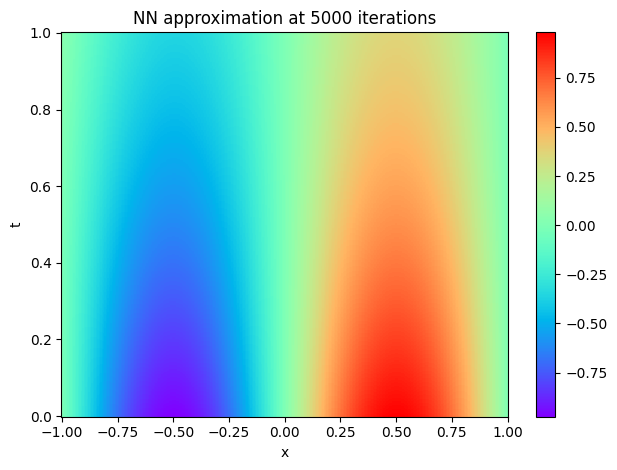

left boundary loss: 2.341293111385312e-05
right boundary loss: 6.5670978983689565e-06
initial values loss: 1.4733257557963952e-05
pde loss: 0.0008498808019794524


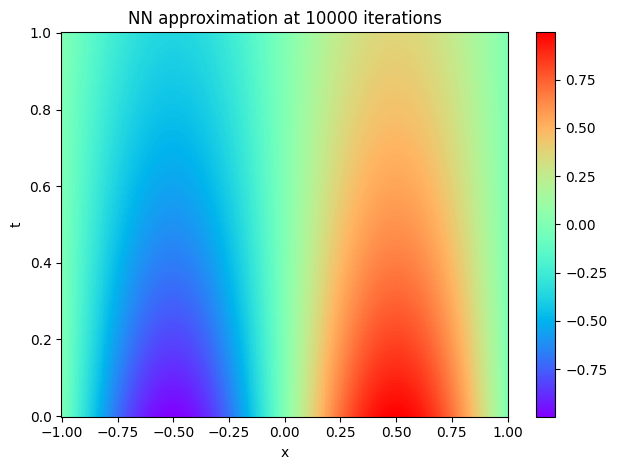

left boundary loss: 6.1750374698021915e-06
right boundary loss: 1.5354448805737775e-06
initial values loss: 3.512664534355281e-06
pde loss: 7.011653360677883e-05


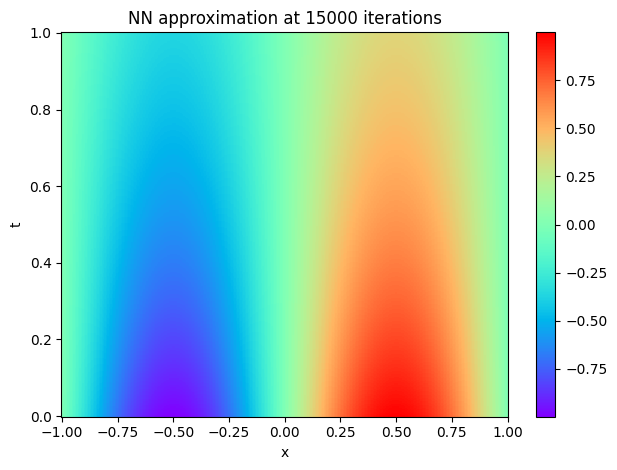

In [38]:
# Initialize an instance of neural network and an optimizer
pinn = XDESolver(n_input=2, n_output=1, n_hidden_layers=4, n_hidden_units=10)
optimizer = torch.optim.Adam(pinn.parameters(), lr=1e-3)

epochs = 15000
pinn.train()
for epoch in range(epochs):
  optimizer.zero_grad()

  #Left boundary losses -> u(x_0,t) = 0
  u = pinn(left_boundary_x, t_axis)
  left_boundary_loss = torch.mean( u**2 )

  #Right boundary losses -> u(x_f, t) = 0
  u = pinn(right_boundary_x, t_axis)
  right_boundary_loss = torch.mean( u**2 )

  #Initial values losses -> u(x, t=0) = sin( pi * x )
  u = pinn(x_axis, bottom_boundary_t)
  init_vals_loss = torch.mean( ( u - torch.sin( pi * x_axis ) )**2 )

  #PDE losses
  u = pinn(x_physics, t_physics)
  dudt = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True)[0]
  dudx = torch.autograd.grad(u, x_physics, torch.ones_like(u), create_graph=True)[0]
  d2udx2 = torch.autograd.grad(dudx, x_physics, torch.ones_like(dudx), create_graph=True)[0]
  pde_loss = torch.mean( ( dudt - d2udx2 + torch.exp(-t_physics) * torch.sin(pi * x_physics) * (1-pi**2) )**2 )

  #combine the losses
  loss = left_boundary_loss + right_boundary_loss + init_vals_loss + pde_loss
  loss.backward()
  optimizer.step()

  if (epoch+1) % 5000 == 0:
    pinn.eval()
    with torch.inference_mode():
      print(f"left boundary loss: {left_boundary_loss}")
      print(f"right boundary loss: {right_boundary_loss}")
      print(f"initial values loss: {init_vals_loss}")
      print(f"pde loss: {pde_loss}")
      test_data = torch.cartesian_prod(x, t)
      x_test, t_test = torch.split(test_data, 1, 1)
      u_approx = pinn(x_test, t_test)
      u_approx = u_approx.reshape(len(t), len(x))
      u_approx = u_approx.cpu()
      plot_data(x, t, exact_solution, u_approx, epoch+1)
    pinn.train()

# Compare
Compare PINN's approximated solution against the exact.

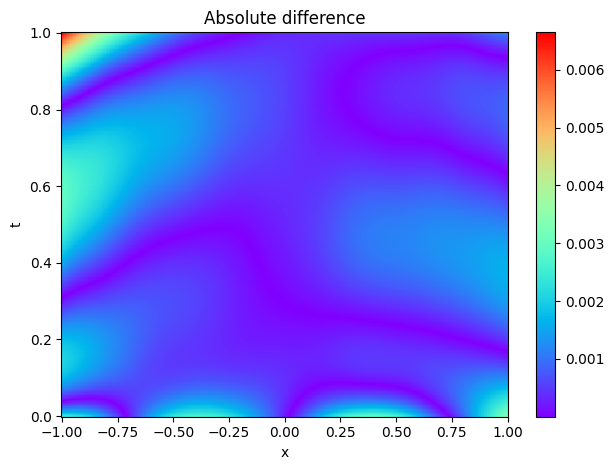

The global error is 0.006645997520536184


In [41]:
u_exact = exact_solution(*torch.meshgrid(x, t))
difference = abs(u_approx - u_exact)
plot_data(x, t, u_exact, difference, epoch=0, title="Absolute difference")
print(f"The global error is {torch.max(difference)}")